#  Analytics Experience - Group Project - MSCI:6040 

By Group 2 (Chris Wagner, Palden Williams, Tarun Mandava  - Data Scientists) 
- September, 2020                                                             

Objective - This project is an exercise in using natural language processing to determine if social media posts meet a pre-specified criterion.  In this case, the test is to determine which social media posts truly reflect information tied to a natural disaster.  For this exercise, we are working with a test dataset of Twitter posts that have been manually reviewed from Kraggle.

Data source:  Real or Not?  NLP with Disaster Tweets dataset from Kaggle

In [3]:
# Dependencies and the libraries to import

import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sn
import matplotlib.pyplot as plt                     
import numpy as np           
import plotly.offline as plyo
#import cufflinks as cf
#plyo.init_notebook_mode()



In [20]:
#  Further library imports

import random
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import defaultdict
import string

from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm
stopwords = stopwords.words('english')
sn.set_context('notebook')

In [4]:
# Importing Kaggler data set


sample_submission_data = pd.read_csv("Data/OriginalData/sample_submission.csv")
test_data = pd.read_csv("Data/OriginalData/test.csv")
train_data = pd.read_csv("Data/OriginalData/train.csv")


In [5]:
sample_submission_data.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Word visualizations

#### Wordcloud logic

In [17]:
#Code sourced from : https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

#import the wordcloud package
from wordcloud import WordCloud, STOPWORDS

#Define the word cloud function with a max of 200 words
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    #define additional stop words that are not contained in the dictionary
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    #Generate the word cloud
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    #set the plot parameters
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

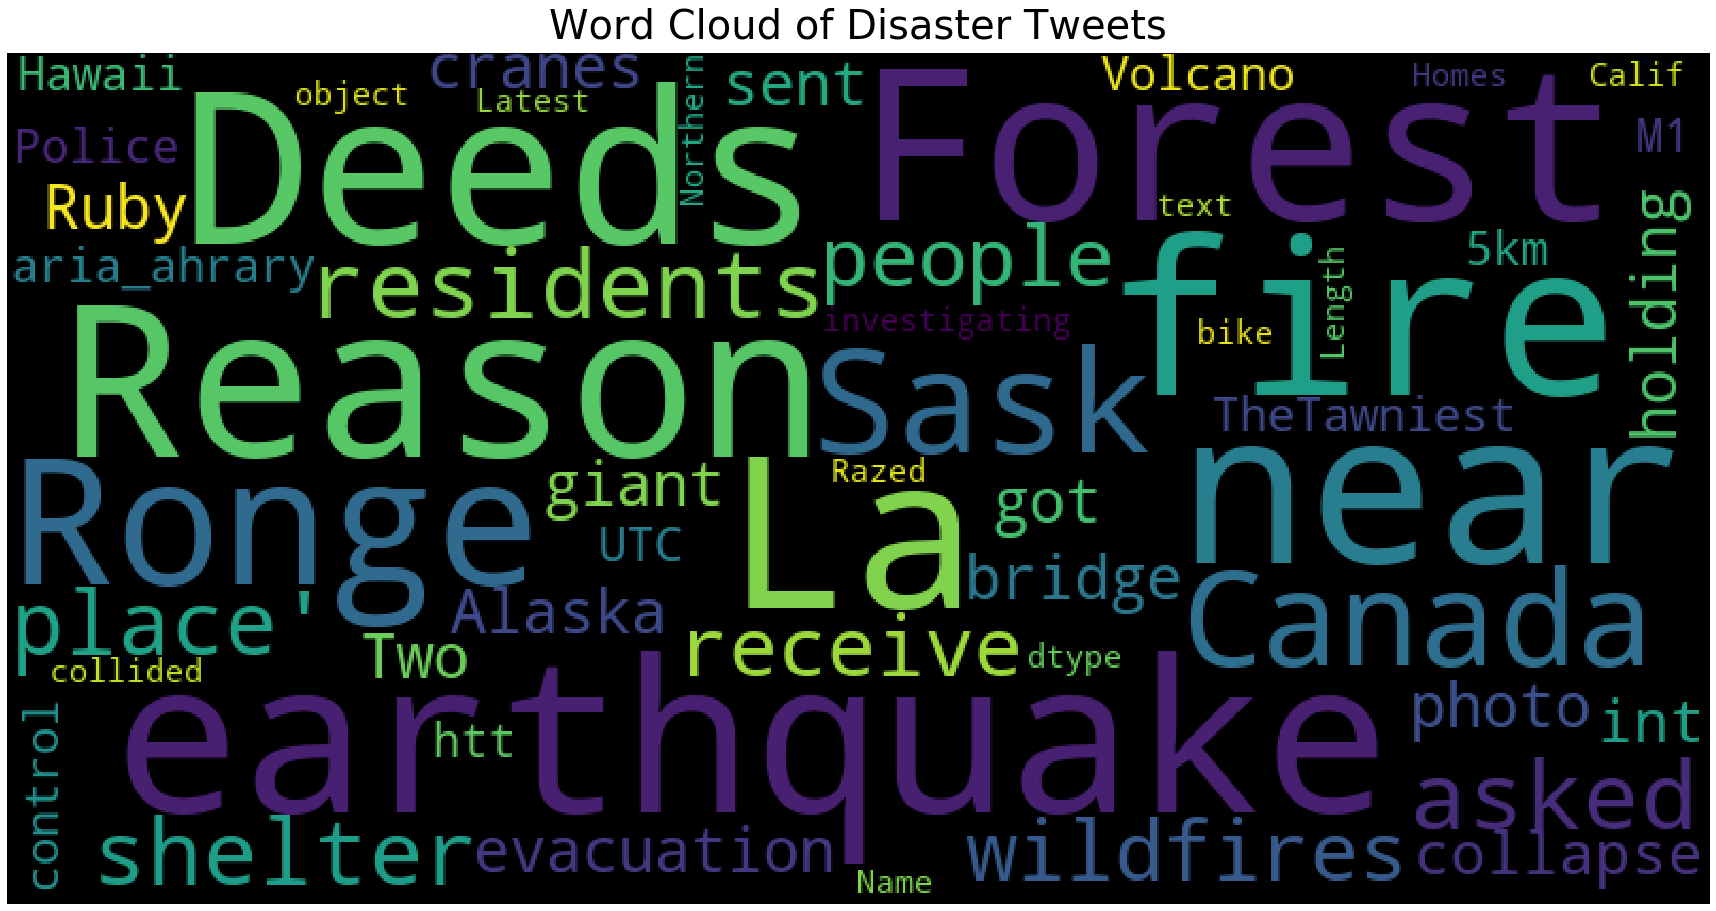

In [18]:
#Select disaster tweets from training dataset
disaster = train_data.loc[train_data['target'] == 1]
#run the function on the insincere questions
plot_wordcloud(disaster["text"], title="Word Cloud of Disaster Tweets")

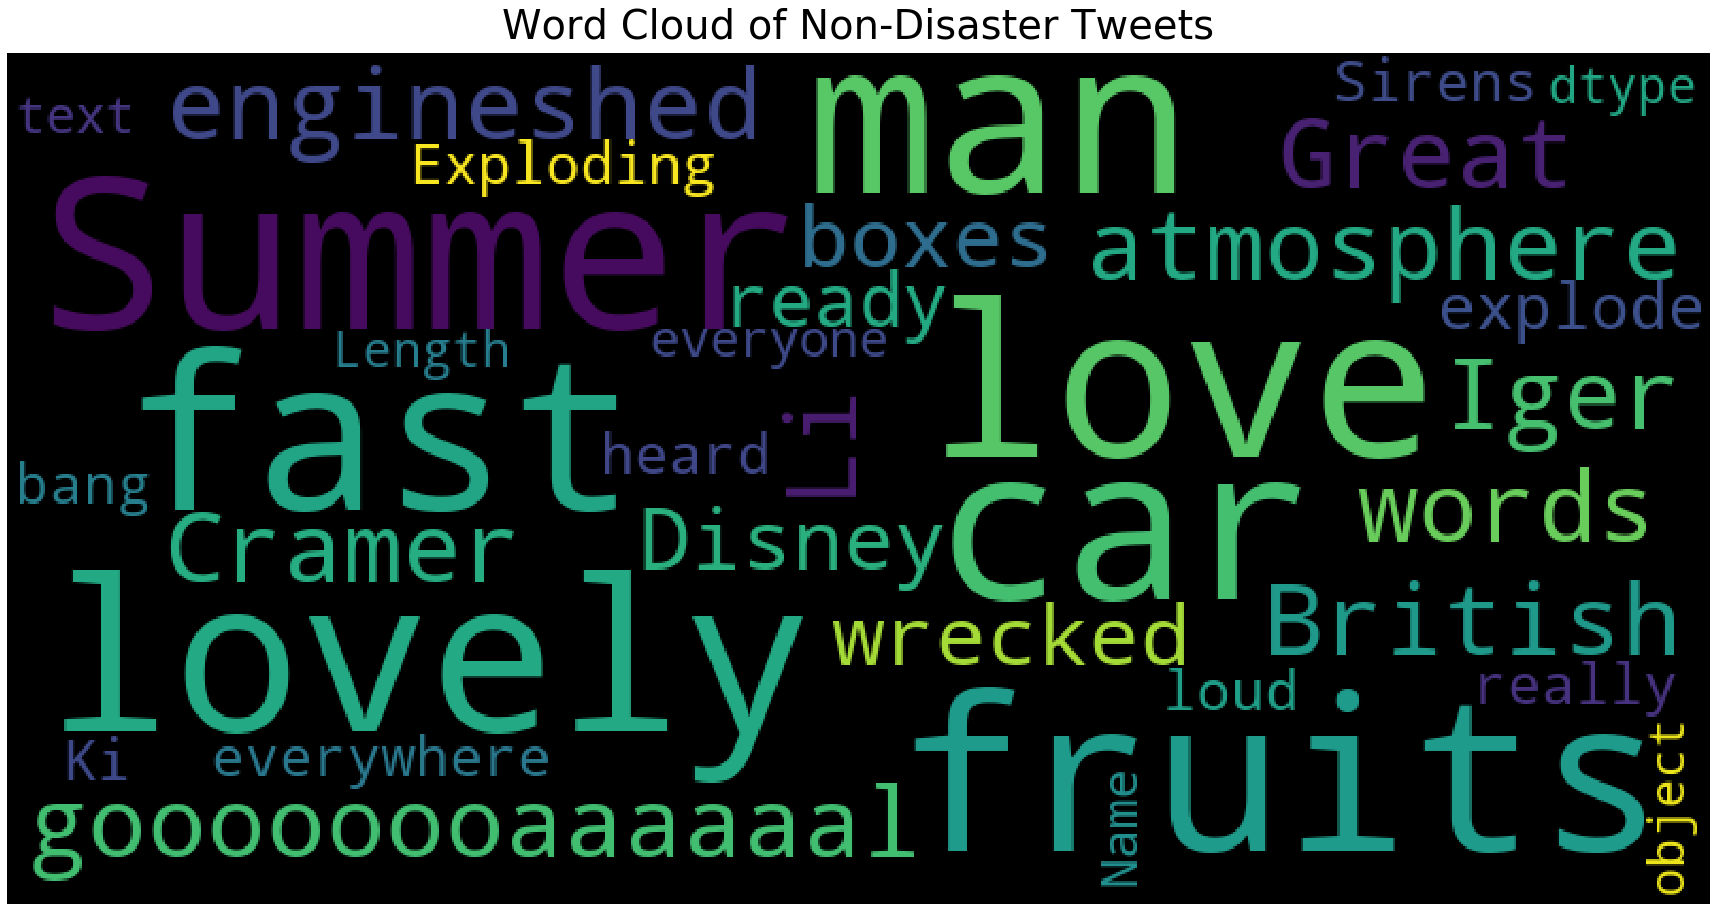

In [19]:
#Select disaster tweets from training dataset
nondisaster = train_data.loc[train_data['target'] == 0]
#run the function on the insincere questions
plot_wordcloud(nondisaster["text"], title="Word Cloud of Non-Disaster Tweets")